# Kickstarter Projects

Kickstarter has been a hub for crowdfunding since 2009 and has launched numerous projects globally. Aside from working to bring ideas to life, entrepreneurs wonder how likely their projects are to succeed or fail, even on an individual platform like Kickstarter.

The document describes an approach to building a tool that an entrepreneur can use to identify chances of success or failure for their Kickstarter project. A tool in the general sense can take in any features that relate to the project, but as far as Kickstarter is concerned, there are a few features that were collected from their website, whether through scraping pages or an API.

It is known that a business idea is not necessarily measured by the features mentioned here, but as long as any Kickstarter project is launched, it should have values for these features that, if used, will help an entrepreneur calibrate their efforts to align with those of project that have already proven their success.

As we go, we will talk about the dataset that we have and methods in which we clean the data, engineer features, and select prediction models. 

Let's begin by our usual import statements and document-wise preferences:

In [1]:
## Import statements
from currency_converter import CurrencyConverter
from collections import Counter
from datetime import date
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier


from IPython.display import Markdown, display

import warnings

# Doc-wise Display preferences.
warnings.filterwarnings('ignore') # Don't show warnings
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
def printmd(string):
    "prints text in bold"
    display(Markdown(string))

## Important Analytical Questions

To get a feel of what this project intends to produce, we will ask three analytical questions that should fixate our efforts and reveal what the reader can expect to find after reading and walking through our project:

#### 1. What features, within the provided dataset, are most determinant of a project's success or failure?
#### 2. Which prediction models - or *algorithms*- perform best in terms of speed, accuracy, and explainability combined?
#### 3. How good is our trained model in predicting future projects (2018 vs. 2016) ?

The first question will be answered once we are done with the feature engineering phase, where we derive, transform and select features from the variables -or *columns*- we have in this dataset. 

The latter two questions will be answered in the last phase, where we select and test our prediction models on both the 2016 and the 2018 datasets.

## Data files

We have two data files, **2016.csv** and **2018.csv**. We will be using the 2016 data to train our prediction model, and the 2018 data to test for prediction.

Let's start by importing the data:

In [2]:
# Import the data
data_2016 = pd.read_csv('2016.csv', encoding='Windows-1252')
data_2018 = pd.read_csv('2018.csv')

data_2016 = data_2016.iloc[:100000,:]
data_2018 = data_2018.iloc[:100000,:]

Now that we have imported the data, the first step is to explore the data we have and clean as we proceed.

## Exploratory Data Analysis

### Data Cleaning

How does our raw data file look like when imported?

In [3]:
data_2016.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,nan
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,nan
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,nan
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,nan
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,nan


We have 4 columns with no names and seemingly no values. Our first task is to find out what brought them to our dataset.

We have:

    - Two strata of categories.
    - A currency column.
    - Two columns describing launch and deadline dates.
    - Goal amount column and amount pledged column, another column describing pledged amount in USD.
    - Number of backers column.
    - A country column.
    - Our prediction target column, describing the state of the Kickstarter project.

Back to our 4 unnamed columns, we will rename them to a, b, c, and d for ease of reference:

In [4]:
# Rename unnamed columns
data_2016.rename(columns={'Unnamed: 13':'a','Unnamed: 14':'b','Unnamed: 15':'c','Unnamed: 16':'d'},inplace=True)

# Display unique values in each previously unnamed column
for i in ['a','b','c','d']:
    printmd (i+':\n')
    print (np.unique(data_2016[i][:25090].astype(str)))

a:


['0' '1010' '103' '11044' '11719' '12306' '125' '126.9669968' '1320'
 '13446.90533288' '13675' '14309.36' '1495' '16' '178' '18' '1800.5'
 '1847.3965377' '20' '2000' '2006.0578219' '2161' '23924' '2630'
 '3.39594898' '3035' '312' '331' '3363' '352' '3671' '3711' '3984' '4451'
 '4488.01' '450' '4690' '4986.41798748' '5' '504.94765278' '525' '5600.65'
 '566.57479307' '590' '630' '65' '687' '8542' '8609.6' '950' 'US' 'nan']


b:


['0.0' '20.0' 'nan']


c:


['nan']


d:


['nan']


Looking at their values and the portion of data displayed above, the additional unknown columns seem to represent rows where values have been misplaced. since we have a considerable number of misplaced rows that can help us in subsequent phases of this project, let's look at these rows and see if they can be put back in place:

In [5]:
# Print column names
print (data_2016.columns)

# Show the part of dataframe where column a has no empty values
data_2016[~data_2016['a'].isnull()].head(3)


Index(['ID ', 'name ', 'category ', 'main_category ', 'currency ', 'deadline ',
       'goal ', 'launched ', 'pledged ', 'state ', 'backers ', 'country ',
       'usd pledged ', 'a', 'b', 'c', 'd'],
      dtype='object')


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,a,b,c,d
1454,1008705746,Zephyra´s new full length,'As The World Collapses',Metal,Music,SEK,2016-02-02 00:56:46,15000,2016-01-03 00:56:46,4262,failed,14,SE,504.94765278,NaN,NaN,nan
1563,1009317190,French Cuisine,A Traditional Experience,Cookbooks,Food,USD,2014-09-08 00:46:23,13730,2014-08-09 03:16:02,3984,failed,46,US,3984,NaN,NaN,nan
1794,1010871699,The Beginners Guide to being Unsuicidal,the one act,Theater,Theater,USD,2011-12-31 23:25:46,5000,2011-11-21 23:25:46,525,failed,10,US,525,NaN,NaN,nan


The first thing we notice is that all original column names have trailing whitespaces, which will be removed. The problem seems to be that some projects have secondary titles, which were carried over to the *category* column, causing a rightward shift in subsequent values for each observation.

We have 625 rows of misplaced data. The good thing is that the data is uniformly misplaced, meaning we can correct all of them in one block of code. Rows that have shifted further with values in columns b, c, or d, will be removed:

In [6]:
# Remove whitespace from column names
data_2016.columns = data_2016.columns.str.strip()

# Put misplaced rows back in place
for index in data_2016[~data_2016['a'].isnull()].index:
    
    # Add secondary title to value in name column
    data_2016.at[index, 'name'] = str(data_2016.at[index, 'name']) + str(data_2016.at[index, 'category'])
    
    # Shift values in subsequent columns to the left
    for i in range(1,14):
        if i == 13:
            break
        data_2016.at[index, data_2016.columns[i]] = data_2016.at[index, data_2016.columns[i+1]]

Let's take a look at what we have left:

In [7]:
data_2016[~data_2016['a'].isnull()].head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,a,b,c,d
1454,1008705746,'As The World Collapses',Metal,Music,SEK,2016-02-02 00:56:46,15000,2016-01-03 00:56:46,4262,failed,14,SE,504.94765278,504.94765278,NaN,NaN,nan
1563,1009317190,A Traditional Experience,Cookbooks,Food,USD,2014-09-08 00:46:23,13730,2014-08-09 03:16:02,3984,failed,46,US,3984,3984,NaN,NaN,nan
1794,1010871699,the one act,Theater,Theater,USD,2011-12-31 23:25:46,5000,2011-11-21 23:25:46,525,failed,10,US,525,525,NaN,NaN,nan
1931,1011687764,Ever / No More Spam,Web,Technology,USD,2014-09-20 19:56:10,6300,2014-08-21 19:56:10,0,failed,0,US,0,0,NaN,NaN,nan
2420,101453314,A Short Film from Adam S Curtis,Shorts,Film & Video,USD,2013-03-14 20:11:57,3000,2013-02-25 21:11:57,3035,successful,42,US,3035,3035,NaN,NaN,nan


Good! Row values are back in place and we are ready to proceed.

In [8]:
# Remove corrupt rows, in addition to columns a, b, c, and d:
# For the index arg, we got indexes of rows that are not null in column b
data_2016.drop(index=data_2016[~data_2016['b'].isnull()].index.to_list(),columns=['a','b','c','d'], inplace=True)

# Drop some more misplaced rows
data_2016.drop(index=data_2016[data_2016['country']=='0'].index.to_list(), inplace=True)


# Missing values
printmd('Missing Values:')
data_2016.isnull().sum()

Missing Values:

ID                  0
name                4
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd pledged      1142
dtype: int64

We only have considerable missing values in the usd pledged column, which should ultimately contain the same amount in the pledged column converted to USD, the names column is not expected to be within the features. Let's look at the pledges regardless of currency and see how it currently looks:

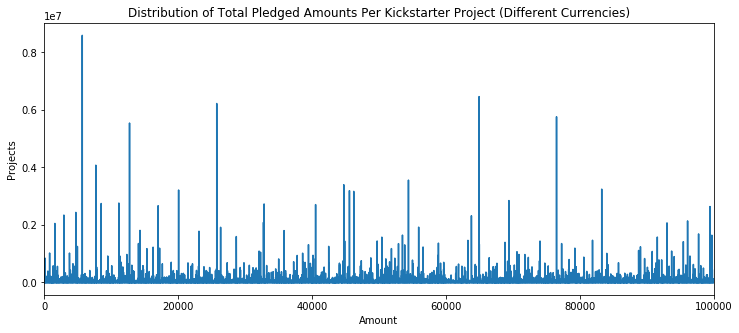

In [9]:
# Assert float data type for the pledged column
data_2016['pledged'] = data_2016['pledged'].astype(float)
# Assert integer data type for the backers column
data_2016['backers'] = data_2016['backers'].astype(int)

# Plot the pledged column
data_2016['pledged'].plot(figsize=(12,5))
plt.title('Plot of Total Pledged Amounts Per Kickstarter Project (Different Currencies)')
plt.xlabel('Amount')
plt.ylabel('Projects')
plt.show()

In [10]:
# For the usd pledged column, how do rows look like when values are null?
data_2016[data_2016['usd pledged'].isnull()].head(3)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
150,1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20 06:59:00,6500,2014-08-06 21:28:36,555.000,undefined,0,"N,""0",NaN
287,100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25 23:00:00,4500,2015-08-04 12:05:17,4767.000,undefined,0,"N,""0",NaN
549,1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09 21:06:13,3500,2015-03-10 20:06:13,3576.000,undefined,0,"N,""0",NaN


The *usd pledged* column is nothing but the same value in the *pledged* column, only converted to USD. After using the different currencies we have to predict missing values in the *country* column (which do not show in the isnull().sum() call above), we will then convert all currencies to USD based on their launch date and will get rid of a few columns in the process:

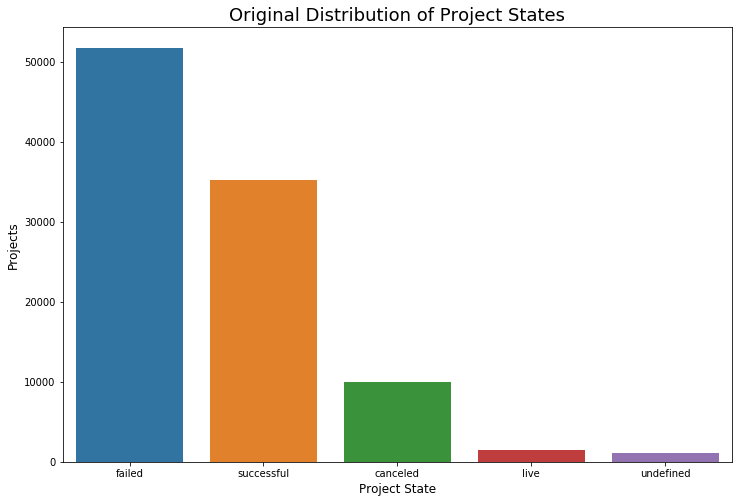

How distribution looks like for null usd pledged column :

canceled projects:

6


failed projects:

32


successful projects:

34


undefined projects:

1070


In [11]:
# Get value count of unique values in the state column
val_ct = data_2016['state'].value_counts()[:5]
val_ct = pd.DataFrame(val_ct).reset_index()

# Plot distribution of project states
plt.figure(figsize=(12,8))
ax = sns.barplot(x='index', y='state',data=val_ct)
plt.title('Original Distribution of Project States',fontsize=18)
plt.xlabel('Project State',fontsize=12)
plt.ylabel('Projects',fontsize=12)
plt.show()

# Show us a simplified count of each state where usd pledged is null
printmd('How distribution looks like for null usd pledged column :')
for state in np.unique(data_2016[data_2016['usd pledged'].isnull()]['state']):
    printmd('{} projects:'.format(state))
    print((data_2016[data_2016['usd pledged'].isnull()]['state']==state).sum())

Not all of these projects are failures. Since we have a significant portion of the data with missing data here, we can try to fill up as much as we can:

- For the country column, we can use fill them in according to the corresponding value in the currency column.


- Projects that are canceled or suspended can also be labeled as failed. Since our goal here to predict whether a project will go through or not, we do not really care whether it was canceled or suspended as long as it will not succeed. Also, projects that are live can be labeled as successful.


- Projects with states that are undefined will be inspected closely before I make a decision on replacing their status.


Let's take a look at countries and currencies used, because the case may be that someone in a country uses another country's currency:

In [12]:
data_2016[['currency','country','ID']].rename(columns={'ID':'count'}).groupby(by=['currency','country']).count()

count
currency country       
AUD      AU        1966
         N,"0        25
CAD      CA        3743
         N,"0        62
CHF      CH         141
DKK      DK         251
         N,"0         6
EUR      AT         134
         BE         129
         DE         814
         ES         435
         FR         599
         IE         172
         IT         573
         LU          17
         N,"0        58
         NL         709
GBP      GB        8553
         N,"0       158
HKD      HK          39
MXN      MX          66
NOK      N,"0         6
         NO         185
NZD      N,"0         8
         NZ         335
SEK      N,"0         8
         SE         393
SGD      SG          41
USD      N,"0       811
         US       79557

A plot can give us a better idea of where Kickstarter projects launched in terms of country:

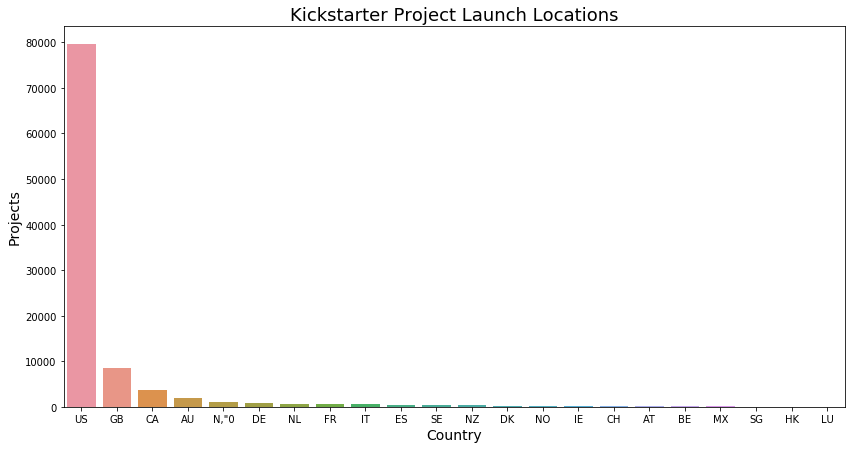

In [13]:
# Get count of countries
np.unique(data_2016['country'])
val_ct = data_2016['country'].value_counts()
val_ct = pd.DataFrame(val_ct).reset_index()
plt.figure(figsize=(14,7))
plt.title('Kickstarter Project Launch Locations',fontsize=18)
ax = sns.barplot(x='index', y='country',data=val_ct)

# Plot distribution of countries
plt.xlabel('Country',fontsize=14)
plt.ylabel('Projects',fontsize=14)
ax.set(xlabel='Country', ylabel='Projects')
plt.show()

To fill in the country column replacing the *N,"0* value, we will build a dictionary containing countries and currencies, then fill accordingly. As for European countries with many possibilities for the Euro, we will fill countries in randomly:

In [14]:
data_2016.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0.000,failed,0,GB,0
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220.000,failed,3,US,220
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1.000,failed,1,US,1
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283.000,canceled,14,US,1283
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375.000,successful,224,US,52375


In [15]:
# Weights for European countries
weights = data_2016[data_2016['country']!= 'N,"0']
weights = weights[weights['currency']=='EUR']['country']
weights = weights.value_counts(normalize=True)


cntry_x_curr = {}

for curr in np.unique(data_2016['currency']):
    
    # slice df containing it
    temp_df = data_2016[data_2016['currency']==curr]
    
    # get unique vals of country, convert to list
    countries = list(np.unique(temp_df['country']))
    
    # remove N,"0 from list
    if 'N,"0' in countries:
        countries.remove('N,"0')
    
    # Set currency as key, countries as value in the dictionary
    cntry_x_curr[curr] = countries


# Loop over rows of N,"0, fill values according to dict
for index in data_2016[data_2016['country']=='N,"0'].index:
    
    # if Euro, select a country randomly
    if data_2016.at[index, 'currency'] == 'EUR':
        data_2016.at[index, 'country'] = random.choices(cntry_x_curr['EUR'], weights=weights)
        continue
        
    # fill country with corresponding currency value
    data_2016.at[index, 'country'] = cntry_x_curr[data_2016.at[index, 'currency']]

Now that we have filled in values for the *country* column, let's move on to replacing *undefined* values for the *state* column:

In [16]:
bin_dict = {'canceled':'failed','failed':'failed', 'live':'successful','successful':'successful','suspended':'failed'}
# Loop over rows of state and 'binarize' values
for index in data_2016.index:
    if data_2016.at[index, 'state'] != 'undefined':
        data_2016.at[index, 'state'] = bin_dict[data_2016.at[index, 'state']]
print('We are left with {} undefined rows.'.format(len(data_2016[data_2016['state']=='undefined'])))

We are left with 1070 undefined rows.


Let's take a look at projects that failed and see whether we can set a threshold for the amount collected as a percentage of the goal amount:

99th Percentile for failed projects: 

0.7558799999999981


Failed projects quick stats:

count   62228.000
mean        0.293
std        46.686
min         0.000
25%         0.000
50%         0.016
75%         0.108
max     11644.110
Name: raised, dtype: float64


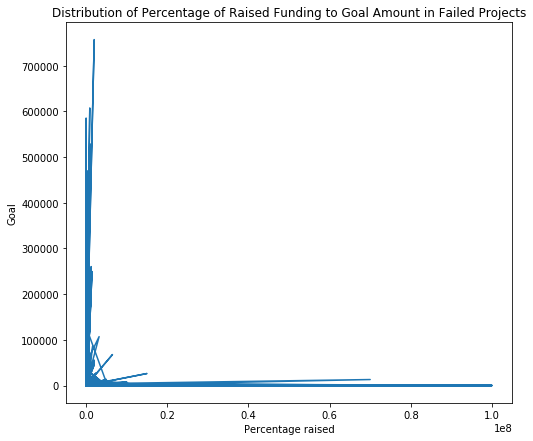

In [17]:
# Assert data types
data_2016['pledged'] = data_2016['pledged'].astype(float)
data_2016['goal'] = data_2016['goal'].astype(float)

# Slice a dataframe to contain only failed projects
fail_df = data_2016[data_2016['state']=='failed']

# Add a column containing percentage of raised funding called "raised"
fail_df['raised'] = fail_df['pledged']/fail_df['goal']

# print the 99th percentile for the raised column
printmd('99th Percentile for failed projects: ')
print(fail_df['raised'].quantile(q=0.99))
printmd('Failed projects quick stats:')
print(fail_df['raised'].describe())

# Plot a figure
plt.figure(figsize=(8,7))
plt.plot(fail_df['goal'],fail_df['pledged'])
plt.title('Distribution of Percentage of Raised Funding to Goal Amount in Failed Projects')
plt.ylabel('Goal')
plt.xlabel('Percentage raised')
plt.show()

In [18]:
# Repeat the same operation in the last code block
success_df = data_2016[data_2016['state']=='successful']
success_df['raised'] = success_df['pledged']/success_df['goal']
printmd('99th Percentile for successful projects: ')
print(success_df['raised'].quantile(q=0.99))
printmd('Successful projects quick stats:')
print(success_df['raised'].describe())

99th Percentile for successful projects: 

22.724316378343836


Successful projects quick stats:

count   36696.000
mean        7.500
std       318.015
min         0.000
25%         1.037
50%         1.145
75%         1.530
max     41535.010
Name: raised, dtype: float64


Seeing the statistics for both failed and successful projects, especially the 99th percentile, we can say with some confidence that successful projects in Kickstarter are defined as projects that meet their goal amount, and therefore we set a rule stating that projcts with *raised* amount equal to 1 (or 100%) are successful projects, and that other projects can be labeled as failed:

In [19]:
# Add the column "raised" to the main df
data_2016['raised'] = data_2016['pledged']/data_2016['goal']

# define undefined columns
for index in data_2016[data_2016['state']=='undefined'].index:
    if data_2016.at[index, 'raised'] >= 1:
        data_2016.at[index, 'state'] = 'successful'
    else:
        data_2016.at[index, 'state'] = 'failed'

def digitize(x):
    """ convert failed and successful values to 0 and 1, respectively """
    if x.lower() == 'failed':
        return 0
    return 1

# Call the digitize function on the state column
data_2016['state'] = data_2016['state'].apply(digitize)

Now that we are done limiting project states to two outcomes. The final step of the data cleaning process is to convert the amount pledged to USD. This is because we have different currencies resulting in two columns, one of which has missing data that needs conversion.

We will convert all currencies to USD and will remove the currency column, along with the usd pledged column to have one remaining column that is enough to sum up all three. This will be done using the currency_converter library, but first we will convert the currency column to include the currency name and the launch date as well the amount, all of which will be fed to the currency converter through the Pandas apply() function:

In [20]:
data_2016.head(3)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,raised
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000.000,2015-08-11 12:12:28,0.000,0,0,GB,0,0.000
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000.000,2013-01-12 00:20:50,220.000,0,3,US,220,0.005
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000.000,2012-03-17 03:24:11,1.000,0,1,US,1,0.000


In [21]:
# Assert dates are in the datetime data type
data_2016['launched'] = pd.to_datetime(data_2016['launched'])
data_2016['deadline'] = pd.to_datetime(data_2016['deadline'])

With most currencies being relatively stable, picking a date in the middle of the year as a mean conversion rate for converting to USD should give us a stable USD equivalent. The exchange rate is picked from a date that suits most of these projects, which is in the middle of 2016. Once done converting, we will drop non useful columns:

In [22]:
# a dictionary to hold exchange rate per currency
rate_dict = {}

# fill in the exchange rate dictionary
for curr in np.unique(data_2016['currency']):
    rate = CurrencyConverter(fallback_on_wrong_date=True).convert(1, curr, 'USD', date=date(2015,6,15))
    rate_dict[curr] = rate
    
# convert the pledged and the goal columns
for index in data_2016.index:
    data_2016.at[index, 'pledged'] = data_2016.at[index, 'pledged']* rate_dict[data_2016.at[index, 'currency']]
    data_2016.at[index, 'goal'] = data_2016.at[index, 'goal']* rate_dict[data_2016.at[index, 'currency']]
    
# drop no-longer-useful columns
data_2016.drop(columns=['currency','usd pledged','ID','name'], inplace=True)
data_2016.columns = data_2016.columns.str.strip()
data_2016.head()

,category,main_category,deadline,goal,launched,pledged,state,backers,country,raised
0,Poetry,Publishing,2015-10-09 11:36:00,1550.733,2015-08-11 12:12:28,0.000,0,0,GB,0.000
1,Narrative Film,Film & Video,2013-02-26 00:20:50,45000.000,2013-01-12 00:20:50,220.000,0,3,US,0.005
2,Music,Music,2012-04-16 04:24:11,5000.000,2012-03-17 03:24:11,1.000,0,1,US,0.000
3,Film & Video,Film & Video,2015-08-29 01:00:00,19500.000,2015-07-04 08:35:03,1283.000,0,14,US,0.066
4,Restaurants,Food,2016-04-01 13:38:27,50000.000,2016-02-26 13:38:27,52375.000,1,224,US,1.048


Having converted all pledged and goal amounts to USD, we no longer need two columns for pledged amounts, nor do we need a currency column to indicate currency. Let's see how the pledged amounts changed after unifying their currency:

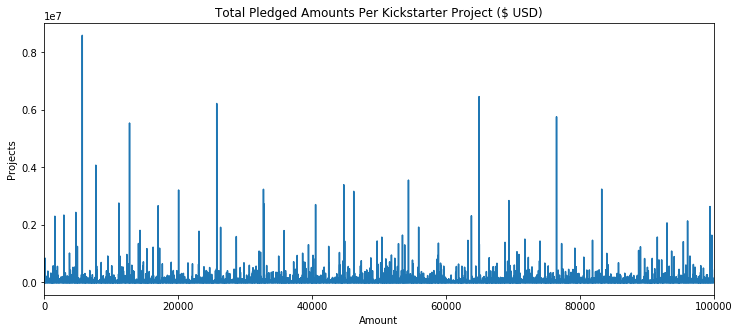

In [23]:
# Assert data type
data_2016['pledged'] = data_2016['pledged'].astype(float)

# plot a figure
data_2016['pledged'].plot(figsize=(12,5))
plt.title('Total Pledged Amounts Per Kickstarter Project ($ USD)')
plt.xlabel('Amount')
plt.ylabel('Projects')
plt.show()

And now we come to answering the first analytical question:

#### 1. What features, within the provided dataset, are most determinant of a project's success or failure?

## Feature Selection and Engineering

Now that we are done cleaning our dataset, we move on to feature selection. There are columns that easily allow for deriving new columns from, such as deriving the fundraising period from the *launched* and *deadline* columns. Advanced techniques such as Principal Component Analysis may not apply to this dataset if we have too few columns.

Since we already have in mind the fundraising duration column, let's start by that:

In [24]:
# Create the duration column and convert its value to integer days
data_2016['duration'] = (data_2016['deadline'] - data_2016['launched']).astype(str)
data_2016['duration'] = [int(str(val)[:-24]) for val in data_2016['duration']]

In [25]:
def positive(x):
    """ prepare values for box cox by ensuring they are positive"""
    if x <= 0:
        return .01
    return x

# Apply the positive function to values intended for box cox transformation
data_2016['pledged'] = data_2016['pledged'].apply(positive)
data_2016['goal'] = data_2016['goal'].apply(positive)
data_2016['raised'] = data_2016['raised'].apply(positive)

# Apply box cox and log transformations
data_2016['pledged'] = boxcox(data_2016['pledged'])[0]
data_2016['goal'] = np.log(data_2016['goal']+1)
data_2016['raised'] = boxcox(data_2016['raised'])[0]
data_2016['duration'] = np.log(data_2016['duration']+1)
data_2016['backers'] = np.log(data_2016['backers']+1)

Having converted both the launched and deadline columns to a duration column, we may say that they can be removed and replaced by the duration column. However, the launch date may be beneficial in contributing to the model by telling us at which time of the year the fundraising was started and therefore can account for time where people in a certain country received tax returns, went through economic prices, or were on vacation.

Initial judgement on the matter is best kept to a correlation matrix, represented by a heat map:

['goal', 'pledged', 'state', 'backers', 'raised', 'duration']


**Correlation Matrix (filtered for correlation above 0.4):**

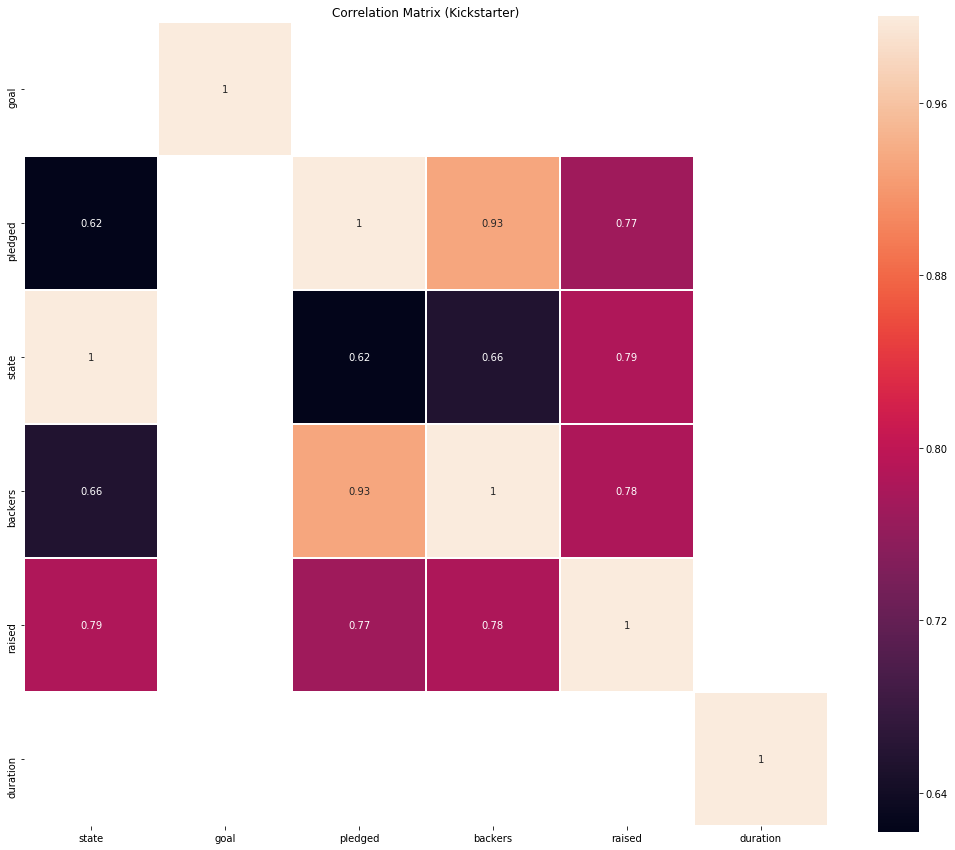

features are: ['pledged', 'backers', 'raised']


In [26]:
def draw_heatmap(df,corr_thresh=.4):
    """ Draws heatmap out of a dataframe. 
        Set corr_thresh to -1000 for full heatmap,
        or keep default for strong correlation
    """
    
    # make the correlation matrix.
    corr_mat = df.corr()

    # move the column to head of list using index, pop and insert
    cols = corr_mat.columns.to_list()
    print (cols)
    cols.insert(0, cols.pop(cols.index('state')))

    # reorder
    corr_mat = corr_mat.ix[:, cols]
    corr_mat.sort_values(by=['state'],ascending=False)

    # figure aesthetics
    plt.figure(figsize=(18,15))
    plt.plot()
    
    # draw the heatmap using seaborn.
    sns.heatmap(corr_mat[(corr_mat > corr_thresh)], square=True, annot=True, linewidths=.5)
    plt.title("Correlation Matrix (Kickstarter)")
    printmd("**Correlation Matrix (filtered for correlation above {}):**".format(corr_thresh))
    plt.show()
    
    # return features that correlate with the target equal to corr_thresh or higher
    features = corr_mat[(corr_mat > corr_thresh)]
    features = features.index[features['state'] >= corr_thresh].tolist()
    features.remove('state')
    print('features are: {}'.format(features))
    return features


features = draw_heatmap(data_2016)

Understandably and without a doubt, the *raised* feature correlates the most with the project state. Since our focus in on the Kickstarter platform - a **fundraising** platform that is-, it makes most sense that project success is judged by the percentage raised with respect to the project's funding goal.

The *backers* and *pledged* features also highly correlate with the *raised* feature. First, because the percentage of raised funding is in part a function of the pledged amount, and secondly because the number of backers can tell much about the perceived status of funding expected. To remove collinearity from our model, we will have to keep *raised* as the only feature. 

Now that we have feature and target sets, we move on to answeing the second analytical question:

### 2. Which prediction models - or *algorithms*- perform best in terms of speed, accuracy, and explainability combined?

## Model Selection

Now that we have chosen our feature(s), we move on to select models that will be trained on the data and, consequentially, tested on the new data. We will choose a slice from the data for training and testing on the 2016 data before we move on to predict data for 2018:

In [27]:
# slice dataframe for quicker algorithm selection
data16 = data_2016.iloc#[:10001,:]

X = data16[['raised']]
y = data16['state']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In order to compare model performance, we need all models to be initialized with their hyperparamters set according to our data. I will create a search space for use with the *GridSearchCV* function in order to find best values for key hyperparameters. Candidate algorithms here are DecisionTrees, RandomForestClassifier, KNeighborsClassifier, LinearSVC, and LinearRegression:

In [28]:
# Cleanup a few lingering objects
for obj in [val_ct, cntry_x_curr, fail_df,  success_df]:
    del obj


In [29]:
# a list that contains algorithms and key hyperparameters
search_space = [
                {RandomForestClassifier():{"n_estimators": [10, 100, 1000],
                 "max_depth":[5,8,15,25,30,None],
                 "min_samples_leaf":[1,2,5,10,15,100],
                 "max_leaf_nodes": [2, 5,10]}},
                {DecisionTreeClassifier():{"criterion":['gini','entropy'],
                 "splitter":['best','random'],
                 "min_samples_split":[2,5,15,50],
                 "max_features":["sqrt",'log2','auto'],
                 "presort":[True,False]}},
                {KNeighborsClassifier():{
                 "n_neighbors": [2,3,5],
                 "weights": ['uniform','distance'],
                 "algorithm": ['ball_tree','kd_tree','brute'],
                 "leaf_size": [2,3,10],
                 "p": [1,2],
                 "n_jobs": [-1]}},    
                {LinearSVC():{"dual": [True,False],
                 "tol": [1e-4, 1e-2, 1e-1],
                 "C": [1,0.6,0.4,0.1],
                 "fit_intercept": [True,False],
                 "max_iter": [300,500,1000,10000]}},
                {LinearRegression():{"fit_intercept":[True,False],
                 "normalize":[True,False]}}
]

# list containing only algorithms
estimators = []
for i in range(len(search_space)):
    estimators += search_space[i].keys()

# list containing only hyperparameters
params = []
for i in range(len(search_space)):
    params += search_space[i].values()

# create a gridsearch of each algorithm and its hyperparameters, the fit the best model
for i in range(len(estimators)):
    gridsearch = GridSearchCV(estimators[i], params[i], cv=5, verbose=0,n_jobs=-1) # Fit grid search
    best_model = gridsearch.fit(X_train, y_train)
    print(best_model.best_estimator_)
    print("The mean accuracy of the model is:",best_model.score(X_test, y_test),'\n')
    del gridsearch

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
The mean accuracy of the model is: 0.984406237504998 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='random')
The mean accuracy of the model is: 0.983606557377

Before we begin testing them individually, let's define a function to plot the AUC curve for each model:

In [30]:
def show_auc(X_test, y_test, model,model_name):
    """
        Shows AUC and correlation matrix
    """
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    # fit a model
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('Baseline: ROC AUC=%.3f' % (ns_auc))
    print('{}: ROC AUC={}+'.format(model_name,lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.figure(figsize=(7,7))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    # axis labels
    plt.title('AUC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    conf_mat = confusion_matrix(y_test, model.predict(X_test))
    printmd('Confusion matrix:\n')
    print(conf_mat)

LinearRegression and LinearSVC did not perform well on our data, or as well as the others. The other three algorithms were able to predict y values with high accuracy. Now that we know the best models for our dataset, let's perform a final check of class imbalance on our dataset before we train the model that we will use for prediction: 

In [31]:
# check for class imbalance
data_2016['state'].value_counts()

0    62810
1    37184
Name: state, dtype: int64

Data is certainly imbalanced, almost on a 2 to 1 ratio for failed to successful classes, respectively. We apply the SMOTE technique from imbalanced-learn to resolve this issue, then we re-run fitting and prediction to score each model individually. We will create a dataframe that stores accuracy and speed data to make an informed decision:

Wall time: 169 ms
Wall time: 3.33 s
Accuracy: 0.9813193228254524
Baseline: ROC AUC=0.500
KNeighborsClassifier: ROC AUC=0.9840930821105257+


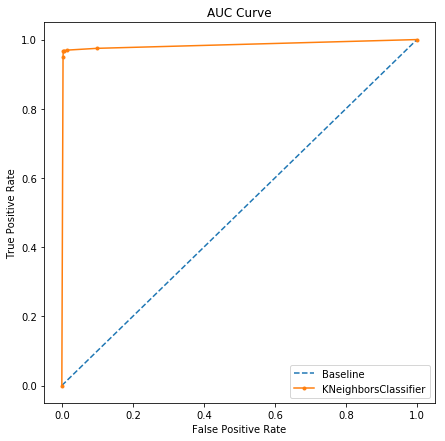

Confusion matrix:


[[18605    98]
 [  606 18377]]


In [32]:
performance = pd.DataFrame(columns=['algorithm','speed(ms)','accuracy'])

X, y = data_2016['raised'].to_numpy().reshape(-1, 1), data_2016['state']

X, y = SMOTE().fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
clf_smote = KNeighborsClassifier(algorithm='ball_tree', leaf_size=2, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')
%time clf_smote = clf_smote.fit(X_train, y_train)
%time acc = clf_smote.score(X_test, y_test)
print('Accuracy: {}'.format(acc))

show_auc(X_test, y_test, clf_smote,'KNeighborsClassifier')

Wall time: 241 ms
Wall time: 15 ms
Accuracy: 0.9818234888287428
Baseline: ROC AUC=0.500
RandomForestClassifier: ROC AUC=0.9839365218669228+


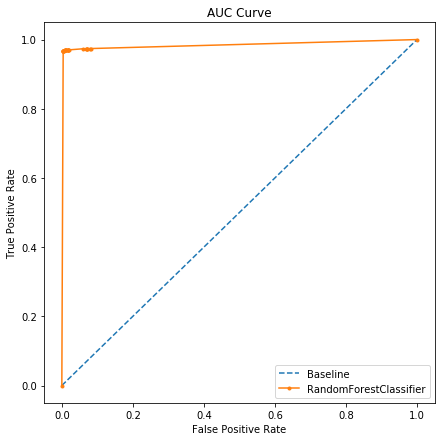

Confusion matrix:


[[18632    71]
 [  614 18369]]


In [33]:
performance = performance.append({'algorithm': 'KNeighborsClassifier', 'speed(ms)': 24500, 'accuracy': acc}, ignore_index=True)

clf_smote = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

%time clf_smote = clf_smote.fit(X_train, y_train)
%time acc = clf_smote.score(X_test, y_test)
print('Accuracy: {}'.format(acc))
show_auc(X_test, y_test, clf_smote,'RandomForestClassifier')

Wall time: 159 ms
Wall time: 6.01 ms
Accuracy: 0.9782677917529056
Baseline: ROC AUC=0.500
DecisionTreeClassifier: ROC AUC=0.9825104519700313+


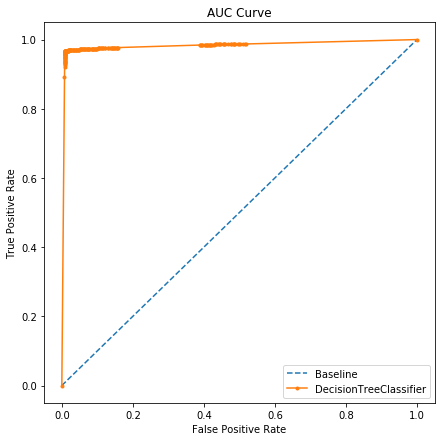

Confusion matrix:


[[18514   189]
 [  630 18353]]


In [34]:
performance = performance.append({'algorithm': 'RandomForestClassifier', 'speed(ms)': 66.8, 'accuracy': acc}, ignore_index=True)
clf_smote = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort=True,
                       random_state=None, splitter='best')

%time clf_smote = clf_smote.fit(X_train, y_train)
%time acc = clf_smote.score(X_test, y_test)
print('Accuracy: {}'.format(acc))
show_auc(X_test, y_test, clf_smote,'DecisionTreeClassifier')

## Model Comparison

The KNN model is great at predicting outcomes from our feature; the AUC is very spacious with a very high true positive rate for predictions. This is also confirmed by the confusion matrix, where true positive and negative predictions are both over 18000 where false predictions for both are 587 and 95, respectively. This makes false predictions almost incomparable to true predictions, showing superiority for our KNN model.

The Random Forest classifier behaves quite similar to the KNN model above; the AUC is also very spacious with a very high true positive rate. The difference is almost non existent in false predictions since false prediction for failed project is a bit less than KNN, but false prediction for successful projects is higher.

Decision trees also has a high AUC but compared to the other two models it has a higher false prediction rate for both positive and negative. Its speed is an added advantage over the preceding models, with its accuracy score being close to theirs as well.

In [35]:
performance = performance.append({'algorithm': 'DecisionTreeClassifier', 'speed(ms)': 22.9, 'accuracy': acc}, ignore_index=True)

performance.sort_values(['accuracy','speed(ms)'],ascending=False)

,algorithm,speed(ms),accuracy
1,RandomForestClassifier,66.800,0.982
0,KNeighborsClassifier,24500,0.981
2,DecisionTreeClassifier,22.900,0.978


A first look at this dataframe can tell that the RandomForestClassifier performs better than KNeighborsClassifier. However, Random Forest falls short on the explainability aspect, being a *black box* algorithm.

As far as answering our third question, here is the detailed answer:

- If we cared about model speed but can let off a little bit of the accuracy, then Decision Trees is the algorithm to use; it can explain the reason behind its classification method while quickly training and testing data.


- If we cared about accuracy and explainability then the model we should pick is KNN; it may perform slower than Random Forest, but it achieves the same accuracy while explaining its predictions with similarity between Kickstarter projects.


- If we did not care about explainability, then Random Forests is the way to go; it is on par with KNN while being much faster to execute.


That being said, I will go forward with our 2018 data prediction using **KNN**.

### Trying with One-Hot Encoding

Since we have the *categories* column included, describing actually *sub*categories of Kickstarted projects, it may be worth seeing if one-hot encoding these would do the model any good by enhancing prediction:

In [36]:
# How many subcategories do we have?
print('We have {} unique categories.'.format(len(np.unique(data_2016['category']))))

# A dataframe that includes dummy variables + the raised column --> All features
one_hot_enc = pd.get_dummies(data_2016['category'],drop_first=True)
trial_df = pd.concat([data_2016['raised'],one_hot_enc])
trial_df = trial_df.fillna(0)

We have 158 unique categories.


In [37]:
# Separate features and target
X, y = trial_df[:len(data_2016['state'])], data_2016['state']

# Balance prediction classes and assign training and testing data
X, y = SMOTE().fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

# Initiate classifier, fit and predict
clf_smote = KNeighborsClassifier(algorithm='ball_tree', leaf_size=2, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')
clf_smote = clf_smote.fit(X_train, y_train)
clf_smote.score(X_test, y_test)

0.9812662527198429

Alright, so dummy variables (one-hot encoded columns) *did* improve our model, but only by a very small percentage. This clearly makes for an insignificant improvement while being a significant burden on the time it takes to train a model. This means that the *raised* column is going to be all the features we need to predict our 2018 data:

### Preparation of testing data

In [38]:
data_2018.head(3)
print(data_2018.isnull().sum())

ID                    0
name                  0
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         988
usd_pledged_real      0
usd_goal_real         0
dtype: int64


Nothing seems out of the usual. Let's prepare testing data so it matches the training data:

In [39]:
# Assert data types
data_2018['pledged'] = data_2018['pledged'].astype(float)
data_2018['goal'] = data_2018['goal'].astype(float)
data_2018['backers'] = data_2018['backers'].astype(int)
data_2018['launched'] = pd.to_datetime(data_2018['launched'])
data_2018['deadline'] = pd.to_datetime(data_2018['deadline'])

# Add the column "raised" to the df
data_2018['raised'] = data_2018['pledged']/data_2018['goal']


# Loop over rows of state and binarize values
for index in data_2018.index:
    if data_2018.at[index, 'state'] != 'undefined':
        data_2018.at[index, 'state'] = bin_dict[data_2018.at[index, 'state']]

# Call the digitize function on the state column
data_2018['state'] = data_2018['state'].apply(digitize)

# a dictionary to hold exchange rate per currency for 2018 data
rate_dict = {}

# fill in the exchange rate dictionary
for curr in np.unique(data_2018['currency']):
    rate = CurrencyConverter(fallback_on_wrong_date=True).convert(1, curr, 'USD', date=date(2017,6,15))
    rate_dict[curr] = rate
    
# convert the pledged and the goal columns
for index in data_2018.index:
    data_2018.at[index, 'pledged'] = data_2018.at[index, 'pledged']* rate_dict[data_2018.at[index, 'currency']]
    data_2018.at[index, 'goal'] = data_2018.at[index, 'goal']* rate_dict[data_2018.at[index, 'currency']]
    
# drop no-longer-useful columns
data_2018.drop(columns=['currency','usd pledged','ID','name'], inplace=True)
data_2018.columns = data_2018.columns.str.strip()
data_2018.head()

def positive(x):
    """ prepare values for box cox by ensuring they are positive"""
    if x <= 0:
        return .01
    return x

# Apply the positive function to values intended for box cox transformation
data_2018['raised'] = data_2018['raised'].apply(positive)

# Apply box cox transformation
data_2018['raised'] = boxcox(data_2018['raised'])[0]

printmd('*** 2018 data is ready for testing ***')

*** 2018 data is ready for testing ***

In the following code block, we will be answering our final analytical question...

### 3. How good is our trained model in predicting future projects (2018 vs. 2016) ?

Wall time: 5.98 ms
Our KNN model can predict future projects with an accuracy of 0.984
Baseline: ROC AUC=0.500
KNeighborsClassifier: ROC AUC=0.9842487340873598+


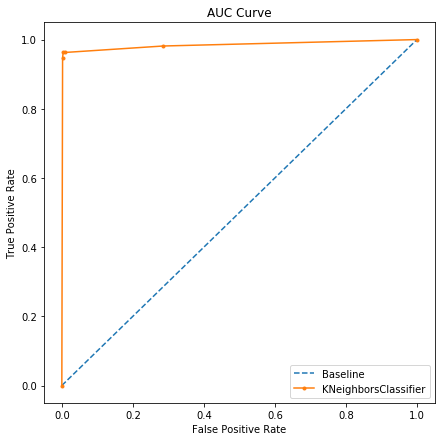

Confusion matrix:


[[1863    7]
 [  42 1088]]
Wall time: 18 ms
Our Random Forest model can predict future projects with an accuracy of 0.984
Baseline: ROC AUC=0.500
RandomForestClassifier: ROC AUC=0.9823214708248544+


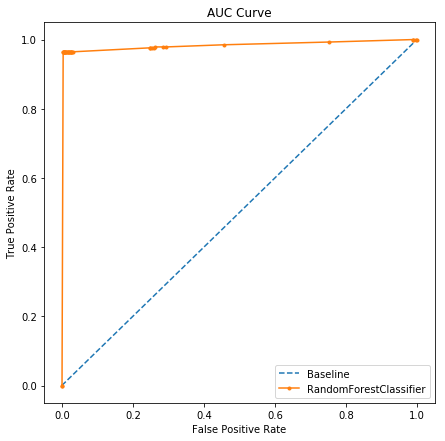

Confusion matrix:


[[1863    7]
 [  42 1088]]


In [40]:
# Slice our data to a third of its size
data_2016 = data_2016.iloc[:10000,:]
data_2018 = data_2018.iloc[:10000,:]

# Training data
X, y = data_2016['raised'].to_numpy().reshape(-1, 1), data_2016['state']
X_train, del_0, y_train, del_1 = train_test_split(X, y, test_size=0.30)

# Testing data
X, y = data_2018['raised'].to_numpy().reshape(-1, 1), data_2018['state']
del_2, X_test, del_3, y_test = train_test_split(X, y, test_size=0.30)

# Cleanup
for obj in [del_0, del_1, del_2,  del_3]:
    del obj

# Balance prediction classes and assign training and testing data
X, y = SMOTE().fit_resample(X, y)

# Train and test data using KNN
clf_smote = KNeighborsClassifier(algorithm='ball_tree', leaf_size=2, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')
%time clf_smote = clf_smote.fit(X_train, y_train)
print('Our KNN model can predict future projects with an accuracy of {}'.format(round(clf_smote.score(X_test, y_test),3)))
show_auc(X_test, y_test, clf_smote,'KNeighborsClassifier')
# Train and test data using Random Forest
clf_smote = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
%time clf_smote = clf_smote.fit(X_train, y_train)
print('Our Random Forest model can predict future projects with an accuracy of {}'.format(round(clf_smote.score(X_test, y_test),3)))
show_auc(X_test, y_test, clf_smote,'RandomForestClassifier')

## Limitations

Before I conclude this document, limitations to our conclusions must be mentioned and considered.

 - Kickstarter project states are not confined to successful and failed, but that confinement is more in the mind of an entrepreneur seeking to launch a successful project. Limiting project states to binary outcomes is only for reasons of simplification and initial model building, making this tool a great add-on to an entrepreneur who has already started their funding campaign on Kickstarter, but not one who is still planning for it.
 
 - Real determinant factors of a project's success include comprehensive planning and execution. Measuring this can yield other variables that *may __not__ necessarily correlate* with the percentage of funding raised, but still add information to the model. These include variables like cost control, how close the product or service is to real market need, and competitive advantage.

## Further Research Proposed

- Time limitation did not allow for one more analysis that focuses on project names as keywords. Names can attract viewers to view the project and may lead to more funding. This is especially hypothesized in two cases:
    1. The name directly addresses a market need while giving the impression of higher efficiency (lower cost, shorter time...etc) to the customer/pledger.
    2. Given the project is solid at its core, meaning it can deliver what is promised, names using buzzwords for the respective year of the project funding campaign may pop up more in searches on search engines and on the Kickstarter platform.
    
- A unified user profile for Kickstarter visitors can also tell us much about what most of them are seeking to fund. This can give weights to categories, and set expectations for projects that do not fall within the preferred categories, such as extending a campaign's duration or setting a lower funding goal.



## Conclusion

Our project included cleaning data for several columns, feature extraction, transformation and selection, in addition to training and testing several supervised learning models on data. The top two models were Random Forests and KNN in terms of accuracy, explainability and speed. Although Random Forest was significantly faster than KNN, KNN still got higher AUC, making it more suitable for accurate prediction. Moreover, since Random Forest is considered a *black box* model, this really leaves KNN with the winner's cup.

We tested these models on both the 2016 and 2018 datasets and found no **generalization gap** (with 2016 being the training dataset). We also tried one-hot encoding categorical variables and did not achieve significant model improvement.

One may say that a single feature that represents percentages may not warrant using machine learning to predict success or failure, but the work put in producing such a feature was not merely dividing one variable by another; it has also included transformation of the target variable, another transformation for the feature itself that was featured by numerous operations perfomed on variables this feature was derived from. It was not clear initially that we may arrive at the usage of one feature, but this feature turned out to have an excellent accuracy score.

The reader needs to remember that project states were converted to a binary possibility of *successful* and *failed*, where the real states used in Kickstarter include 3 other states. This was done for the purposes of developing a binary supervised model capable of accurately predicting the two most important outcomes in real life.

Optimal usage of this tool is expected **after** a project's initial launch period, where usual advertising of such a fundraising campaign is at its highest, and where response from pledgers peaks in response. Its predictions are to be understood as an answer to the question: "*How does my project look like in terms of success of fundraising on Kickstarter?*"